In [1]:
%matplotlib notebook
import os
import time
import platform

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import schemes_dev as sc
import pandas as pd

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})


In [2]:
class model_param:
    def __init__(self):
        self.adjoint = False    # Method of integration
        self.batch_time=30     # Time duration of training batch in terms of Δt steps
        self.batch_size=30     # Number of batches of training data
        self.lr = 1e-4         # Learning rate for model parameters
        self.lr_τ = 1e-5       # Leaning rate delay vector τ
        self.Nc = 40         # Maximum delay in terms of Δt steps
        self.niters=2000       # Maximum number of iterations
        self.test_freq=1       # Testing frequency in terms of iterations (for print and plot)
        self.viz=True          # Visualization
        self.savefig= True     # Set True to save figure
        self.folder='output_folder'   # folder name to store output
        self.use_gpu = False
        self.restart = False
        self.gpu = 0
        self.datafile = "path_to_data_file.txt"
        self.dimensions = 4
        
    def to(self, device):
        args_dir = dir(self)
        for var in args_dir:
            if type(getattr(self, var)) == int or type(getattr(self, var)) == int:
                exec('self.'+var+'=torch.tensor(self.'+var+').to(device)')
                #print(var+'='+ str(getattr(self,var)))


In [3]:
param_df = pd.read_csv("Lorenz/Param.csv")
column_name = list(param_df.keys())

In [4]:
def fun_run(i):
    args = model_param()
    for var in column_name[1:]:
        #print('args.lr_τ=param_df.iloc['+str(i)+']["'+var+'"]')
        if var=='lr_tau':
            exec('args.lr_τ=param_df.iloc['+str(i)+']["'+var+'"]')
        else:
            exec('args.'+var+'=param_df.iloc['+str(i)+']["'+var+'"]')
    return args

In [5]:
args_all = []
loss_all = []
delay_all = []

In [6]:
for i in range(len(param_df)):
    args_all.append(fun_run(i))
    folder = args_all[i].folder
    loss_all.append(np.loadtxt(folder+'/loss.txt'))
    delay_all.append(np.loadtxt(folder+'/delay.txt'))

FileNotFoundError: Lorenz/LorenzNoisy_1D/loss.txt not found.

In [7]:
diff = 'datafile' # How to catagorize data

# Loss plots

In [8]:
catagory = {'Clean':[],'Noisy':[]}
catagory_keys = list(catagory.keys())

In [9]:
for i in range(len(param_df)):
    loss_avg = np.mean(loss_all[i][-100:])
    dim = args_all[i].__dict__['dimensions']
    
    for key in catagory_keys: 
        if key.lower() in args_all[i].__dict__[diff].lower():
            catagory[key].append([dim, loss_avg])

In [10]:
arr_plot = np.array(catagory['Noisy'])

<IPython.core.display.Javascript object>


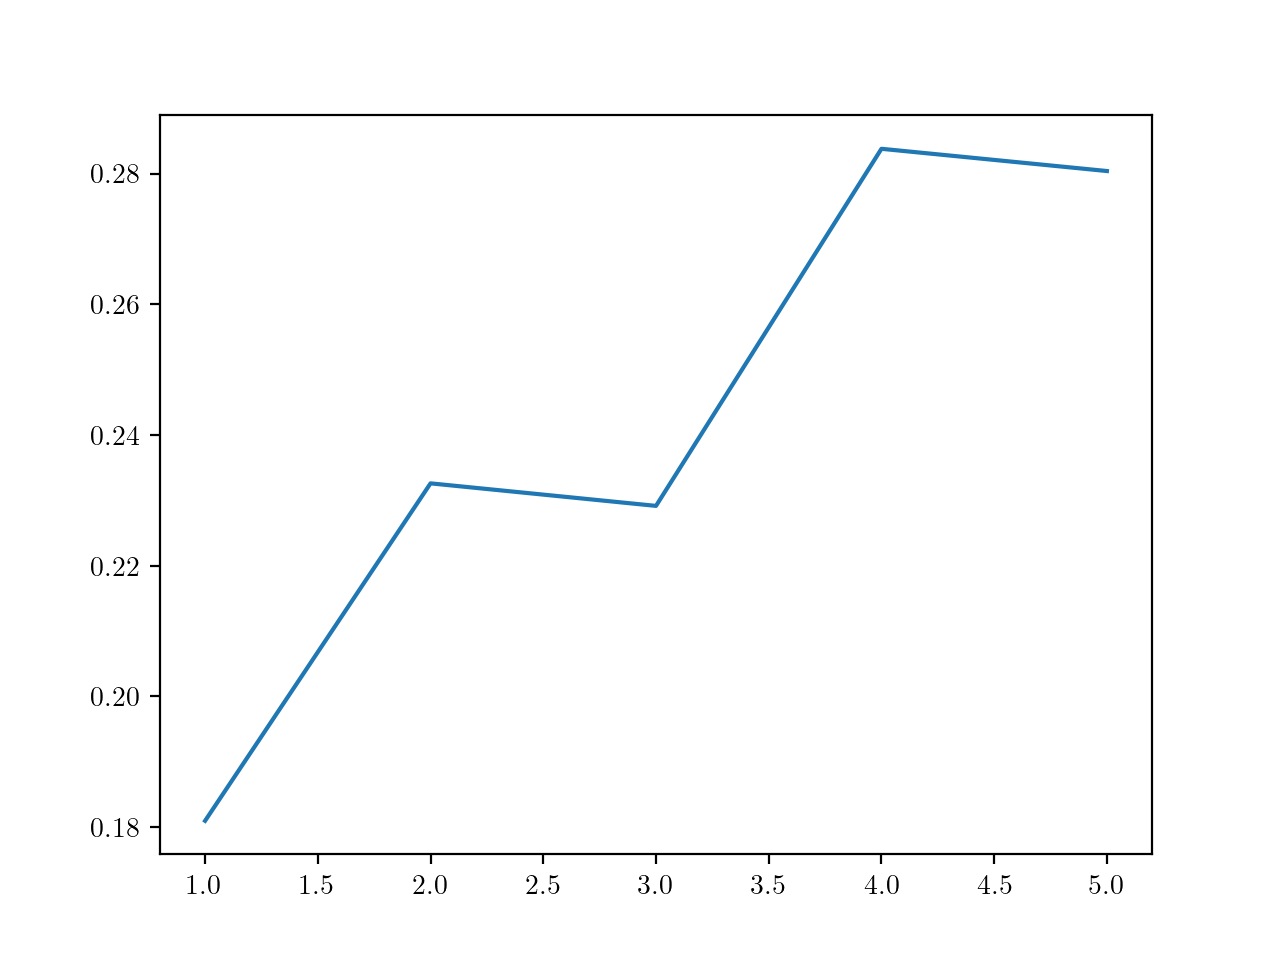

In [11]:
fig = plt.figure()
axs = fig.add_subplot(1,1,1)
axs.plot(arr_plot[:,0],arr_plot[:,1])

In [12]:
catagory

{'Clean': [[1, 0.17712679490447045],
  [2, 0.22854691073298455],
  [3, 0.22356642916798591],
  [4, 0.2640779013931751],
  [5, 0.2702905136346817]],
 'Noisy': [[1, 0.18095507055521012],
  [2, 0.2325977735221386],
  [3, 0.2291503705084324],
  [4, 0.2837987449765205],
  [5, 0.2803961057960987]]}